# FCN训练HRSC-Sea，测试HRSC-Land，分析舰船标签效果

标签使用15类目标的旋转框 DOTA-v1.0\train\labelTxt-v1.0\labelTxt

BBAVectors旋转目标检测算法安装部署使用笔记
https://blog.csdn.net/qq_40608730/article/details/119600956

python opencv minAreaRect 生成最小外接矩形
https://blog.csdn.net/lanyuelvyun/article/details/76614872

OpenCV-Python 形状轮廓拟合
https://blog.csdn.net/qq_38828370/article/details/119759530

#1 假设对图片上任意点(x,y)，绕一个坐标点(rx0,ry0)逆时针旋转a角度后的新的坐标设为(x0, y0)，有公式：  
#2 x0= (x - rx0)*cos(a) - (y - ry0)*sin(a) + rx0  
#3 y0= (x - rx0)*sin(a) + (y - ry0)*cos(a) + ry0  
https://www.cnblogs.com/lyj0123/p/15741652.html

python cv2截取不规则区域图片
https://www.cnblogs.com/gmhappy/p/11863932.html

In [1]:
import collections
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F 
from torchvision.models import resnet
import numpy as np
import pdb
import matplotlib.pyplot as plt
import sys

### 载入数据

In [2]:
%matplotlib inline
import argparse
def parse_args():
    parser = argparse.ArgumentParser(description='BBAVectors Implementation')
    parser.add_argument('--dataset', type=str, default='dota', help='Name of dataset') #dota格式标签
    parser.add_argument('--data_dir', type=str, default='D:/Datasets/HRSC', help='Data directory')
    parser.add_argument('--batch_size', type=int, default=8, help='Number of batch size')
    parser.add_argument('--num_workers', type=int, default=0, help='Number of workers') #0, BrokenPipeError: [Errno 32] Broken pipe
    parser.add_argument('--phase', type=str, default='train', help='Phase choice= {train, test, eval}')
    parser.add_argument('--input_h', type=int, default=256, help='Resized image height') #256
    parser.add_argument('--input_w', type=int, default=256, help='Resized image width')  #256
    parser.add_argument('--K', type=int, default=500, help='Maximum of objects')
    parser.add_argument('--conf_thresh', type=float, default=0.18, help='Confidence threshold, 0.1 for general evaluation')
    
    parser.add_argument('--resume', type=str, default='SAMMIE_HRSC_FCN_model_last.pth', help='Weights resumed in testing and evaluation')
    
    #由于在jupyter notebook中，args不为空。
    args = parser.parse_args(args=[])
    return args

In [3]:
import func_utils
from datasets.dataset_dota import DOTA
from datasets.dataset_hrsc import HRSC

args = parse_args()
print(args.data_dir)
print(args.resume)


dataset = {'dota': DOTA, 'hrsc': HRSC}
dataset_module = dataset[args.dataset]

D:/Datasets/HRSC
SAMMIE_HRSC_FCN_model_last.pth


In [4]:
down_ratio = 1
dataset_phase = {'dota': ['train','test'], 'hrsc': ['train', 'test']}

dsets = {x: dataset_module(data_dir=args.data_dir,
                           phase= x,
                           input_h=args.input_h,
                           input_w=args.input_w,
                           down_ratio=down_ratio)
         for x in dataset_phase[args.dataset]}

In [5]:
dsets['train'].cat_ids  # 只有ship = 6

{'plane': 0,
 'baseball-diamond': 1,
 'bridge': 2,
 'ground-track-field': 3,
 'small-vehicle': 4,
 'large-vehicle': 5,
 'ship': 6,
 'tennis-court': 7,
 'basketball-court': 8,
 'storage-tank': 9,
 'soccer-ball-field': 10,
 'roundabout': 11,
 'harbor': 12,
 'swimming-pool': 13,
 'helicopter': 14}

In [6]:
print('dataset num:', len(dsets['train']),len(dsets['test']))

dataset num: 218 1462


In [7]:
import torch
def collater(data):
    out_data_dict = {}
    for name in data[0]:
        out_data_dict[name] = []
    for sample in data:
        for name in sample:
            #pdb.set_trace()
            out_data_dict[name].append(torch.from_numpy(sample[name])) #
    for name in out_data_dict:
        out_data_dict[name] = torch.stack(out_data_dict[name], dim=0)
    return out_data_dict

dsets_loader = {}
dsets_loader['train'] = torch.utils.data.DataLoader(
    dsets['train'],
    batch_size=args.batch_size,
    shuffle=False,
    num_workers= args.num_workers, #0,  # 此处必须重新执行              
    pin_memory=False, # True,
    drop_last=True,
    collate_fn=collater)

dsets_loader['test'] = torch.utils.data.DataLoader(
    dsets['test'],
    batch_size=args.batch_size,
    shuffle=False,
    num_workers= args.num_workers, #0,  # 此处必须重新执行              
    pin_memory=False, # True,
    drop_last=True)

In [8]:
next(iter(dsets_loader['train'])).keys(), next(iter(dsets_loader['test'])).keys()

(dict_keys(['input', 'hm', 'reg_mask', 'ind', 'wh', 'reg', 'cls_theta', 'rect', 'cat']),
 dict_keys(['image', 'img_id', 'image_w', 'image_h']))

# 配置模型和损失函数

In [26]:
model = torchvision.models.segmentation.fcn_resnet50(pretrained=False, progress=True, num_classes=3, aux_loss=None)

In [27]:
print(args.resume)
model.load_state_dict(torch.load(args.resume)) #加载模型参数

SAMMIE_HRSC_FCN_model_last.pth


<All keys matched successfully>

In [28]:
#model.load_state_dict(torch.load('SAMMIE_Ship_FCN_model_last.pth'))
model.load_state_dict(torch.load('SAMMIE_Sea_FCN_model_last.pth'))

<All keys matched successfully>

In [29]:
X_example = data_dict['input'].cpu()
X_example.shape

y = model(X_example)['out']
y.shape

torch.pow(X_example - y,2).sum()
torch.tensor(X_example.shape).cumprod(dim=0)[-1]

tensor(1572864)

In [30]:
# 损失和优化函数
class SquaredErrorLoss(nn.Module):
    def __init__(self):
        super(SquaredErrorLoss, self).__init__()
        
    def forward(self, X, Y):
        input_shape = torch.tensor(X.size())
        Error = torch.pow(X - Y, 2).sum() / input_shape.cumprod(dim=0)[-1]
        return Error
    

loss_f = SquaredErrorLoss()  #torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

loss_f(X_example, y)

tensor(0.1228, grad_fn=<DivBackward0>)

In [31]:
pred = torch.mean(pow(X_example - y,2), dim=[1])
pred.mean(dim=[1,2])

tensor([0.0722, 0.1289, 0.1599, 0.0813, 0.1471, 0.1104, 0.1375, 0.1448],
       grad_fn=<MeanBackward1>)

In [32]:
import collections
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.nn.functional as F
import time
import pdb
import os

In [22]:
# 配置GPU，开始进行训练
Use_gpu = torch.cuda.is_available()

if Use_gpu:
    print( torch.cuda.get_device_properties(device = 0) )
    model = model.cuda()
    
# 配置多GPU
if torch.cuda.device_count() > 1:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

_CudaDeviceProperties(name='NVIDIA GeForce GTX 1080', major=6, minor=1, total_memory=8192MB, multi_processor_count=20)
Let's use 2 GPUs!


In [23]:
epoch_n = 400  #2
time_open = time.time()
f = open('Loss_log.txt', 'a+')

for epoch in range(epoch_n):
    print("Epoch {}/{}".format(epoch, epoch_n - 1))
    print("-"*10)
    
    for phase in ["train"]: #, "valid"
        if phase == "train":
            print("Training...")
            model.train(True)
        else:
            # 把BatchNormalization和DropOut固定住，不会取平均，而是用训练好的值
            print("Valid...")
            model.train(False) 
            
        running_loss = 0.0
        running_corrects = 0.0
        ship_error = []
        
        # 组合为一个索引序列
        for batch, data_dict in enumerate(dsets_loader['train'], start = 1):
            
            X = data_dict['input']
            y = data_dict['hm']
            
            if Use_gpu:
                X, y = Variable(X.cuda()), Variable(y.cuda())
            else:
                X, y = Variable(X), Variable(y)
            
            y_pred = model.forward(X)['out']
            error_map = torch.pow(X - y_pred, 2)
            pred = torch.mean(error_map, dim=[1])
            
            # Squared Error Loss
            loss = loss_f(y_pred, X) 
            
            # 对参数梯度的归零
            optimizer.zero_grad()
            if phase == "train":
                # 计算反向传播梯度值 P167
                loss.backward() 
                # 对节点的参数进行梯度更新 P169
                optimizer.step()
                
            running_loss += float(loss.data)
            running_corrects += float(torch.sum(pred.mean(dim=[1,2])))
            
            if batch%10000 == 0 and phase == "train":
                print("Batch {}, Train Loss:{:.4f}, Train ACC:{:.4f}"
                      .format(batch, running_loss/batch, 100*running_corrects/batch/ len(pred)))
                print("Current time {:.2f} min".format((time.time() - time_open)/60))
            
            # 分析舰船位置的结果
            # error_map = pow(y_pred - X, 2) #sl 
            for bat,num in itertools.product(range(data_dict['rect'].shape[0]),
                       range(data_dict['rect'].shape[1])):
                rect = data_dict['rect'][bat,num]
                if sum(rect) <= 0:
                    continue
                #print(rect)
                Ew,Eh = (3, 1.5) #扩大宽和长，包含周围环境
                if rect[2] > rect[3]:
                    w,h = rect[2] * Eh,rect[3] * Ew
                else:
                    w,h = rect[2] * Ew,rect[3] * Eh
                img = error_map[bat].permute([1,2,0])
                target = rectCrop(img, (rect[0],rect[1],w, h,rect[4]))
                ship_error.append( float(target.sum()/((target>0).sum())) )
                #plt.imshow( np.array(target.detach().cpu()) + 0.7  )
                #plt.show()
                #pdb.set_trace()
                
        epoch_loss = running_loss*dsets_loader['train'].batch_size/len(dsets_loader['train'])
        #epoch_acc = 100*running_corrects/len(dsets_loader['train'])
        epoch_acc = np.mean(ship_error)
        
        print("{} Loss:{:.6f}  Acc:{:.6f}%".format(phase, epoch_loss, epoch_acc))
        f.write("{} Loss:{:.6f}  Acc:{:.6f}%\n".format(phase, epoch_loss, epoch_acc))
        time_end = time.time() - time_open
        print("Finish time {:.2f} min".format(time_end/60))

f.close()
if torch.cuda.device_count() > 1:
    torch.save(model.module.state_dict(), args.resume)
else:
    torch.save(model.state_dict(), args.resume)

Epoch 0/1
----------
Training...


C:\ProgramData\Anaconda3\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


train Loss:0.247207  Acc:0.059567%
Finish time 0.76 min
Epoch 1/1
----------
Training...
train Loss:0.129194  Acc:0.058515%
Finish time 1.39 min


In [ ]:
import matplotlib.pyplot as plt
from skimage import io

n = 5
img = np.array(pow((X-y_pred),2)[n,:,:,:].detach().cpu().mean(dim=0))
io.imshow(np.array( X[n,:,:,:].detach().cpu().permute([1,2,0])))
plt.figure()
plt.imshow(img, cmap=plt.cm.jet)
plt.colorbar()

In [101]:
pow((X-y_pred),2)[5,:,:,:].detach().cpu().mean(dim=0)

tensor([[0.0002, 0.0002, 0.0005,  ..., 0.0006, 0.0006, 0.0007],
        [0.0004, 0.0004, 0.0004,  ..., 0.0007, 0.0009, 0.0007],
        [0.0004, 0.0003, 0.0002,  ..., 0.0007, 0.0007, 0.0009],
        ...,
        [0.0027, 0.0030, 0.0018,  ..., 0.0019, 0.0018, 0.0019],
        [0.0026, 0.0024, 0.0015,  ..., 0.0018, 0.0015, 0.0023],
        [0.0027, 0.0027, 0.0031,  ..., 0.0015, 0.0019, 0.0027]])

# 图像分割，陆地区域对比测试

In [39]:
import os
args.data_dir = 'D:/Datasets/HRSC'
image_set_index_file = os.path.join(args.data_dir, 'Segmentations.txt')

with open(image_set_index_file, 'r') as f:
    lines = f.readlines()
segm_lists = [line.strip() for line in lines]

In [40]:
model.train(False) 

land_error = []
ship_error = []
sea_error = []

for index in range(len(segm_lists)):
    filename = segm_lists[index]
    imgFile = os.path.join(args.data_dir,'images',filename +'.png')
    labelFile = os.path.join(args.data_dir,'labelTXT',filename+'.txt')
    segmFile = os.path.join(args.data_dir,'Segmentations',filename+'.png')
    
    image = cv2.imread(imgFile)
    segm  = cv2.imread(segmFile)
    annotation = load_annotation(image, labelFile)
    
    # 预处理image
    image = cv2.resize(image, [args.input_h, args.input_w])
    image = np.asarray(np.clip(image, a_min=0., a_max=255.), np.float32)
    #image = self.image_distort(np.asarray(image, np.float32))
    image = np.asarray(np.clip(image, a_min=0., a_max=255.), np.float32)
    image = np.transpose(image / 255. - 0.5, (2, 0, 1))
    
    # 预处理 Segmentation，提取白色陆地区域
    segm = cv2.resize(segm, [args.input_h, args.input_w])
    idx = np.where((segm[:,:,0]>250)*(segm[:,:,1]>250)*(segm[:,:,2]>250))
    segmLand = np.zeros(segm.shape)
    segmLand[idx] = (1,1,1)
    #plt.imshow((segmLand+0.5) * np.transpose(image+0.5, (1,2,0)) )
    
    # 预处理 Segmentation，提取黑色海洋区域
    segm = cv2.resize(segm, [args.input_h, args.input_w])
    idx = np.where((segm[:,:,0]<5)*(segm[:,:,1]<5)*(segm[:,:,2]<5))
    segmSea = np.zeros(segm.shape)
    segmSea[idx] = (1,1,1)
    
    # 正向传播
    device = next(model.parameters()).device
    X = torch.tensor(image,device=device).unsqueeze(0)
    segm = torch.tensor(segmLand, device=device)
    
    y_pred = model.forward(X)['out']
    error_map = torch.pow(X - y_pred, 2)
    pred = torch.mean(error_map, dim=[1])
    if ((index+1)/len(segm_lists)*100)%25 == 0:
        print("proceeding {}%, Error Map: {}".format(index*100//len(segm_lists),
                                                 error_map.mean()))
    
    boxList= []
    maskShip = np.zeros(np.transpose(image,[1,2,0]).shape)
    for pts in annotation['rect']:
        #print(pts)
        x,y,w,h, angle= pts[:5]
        Ew,Eh = (3, 1.5) # #扩大宽和长，包含周围环境
        if w > h:
            w,h = w * Eh, h * Ew
        else:
            w,h = w * Ew, h * Eh
        # 获取最小外接矩形的4个顶点坐标
        box = cv2.boxPoints(((x,y),(w,h),angle)) 
        box = np.int0(box)
        boxList.append(box)
        mask = np.zeros(np.transpose(image,[1,2,0]).shape)
        cv2.fillPoly(mask, [box], (1,1,1))
        maskShip = maskShip + mask
    maskShip[maskShip>1] = 1
    
    
    
    target = error_map[0].permute([1,2,0]).cpu().detach().numpy() * maskShip
    ship_error.append( float(target.sum()/((target>0).sum())) )
    
    target = error_map[0].permute([1,2,0]).cpu().detach().numpy() * segmLand
    land_error.append( float(target.sum()/((target>0).sum())) )
    
    target = error_map[0].permute([1,2,0]).cpu().detach().numpy() * segmSea
    sea_error.append( float(target.sum()/((target>0).sum())) )
    
    """
    image = cv2.drawContours( np.transpose(image,[1,2,0])+0.5, boxList, -1, (0,255,0), 1)
    cv2.imshow('img',image * (segmLand + maskShip*0.5 + 0.1))
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    """

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in double_scalars


proceeding 24%, Error Map: 0.025295088067650795
proceeding 49%, Error Map: 0.03928942605853081
proceeding 74%, Error Map: 0.035833682864904404


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in double_scalars


proceeding 99%, Error Map: 0.05245853587985039


In [41]:
import pandas as pd
count_error =  pd.DataFrame({'list':segm_lists,'ship':ship_error, 'land':land_error, 'sea':sea_error} )
count_error = count_error.sort_values(by="ship",axis=0,ascending=False,inplace=False)
count_error.head()

,list,ship,land,sea
257,100001237,0.160230,0.215463,0.112766
256,100001236,0.157067,0.190824,0.105875
258,100001241,0.152837,0.159449,0.111697
367,100001512,0.150746,0.172153,0.011608
298,100001369,0.142352,0.161968,0.024587


In [42]:
count = count_error.dropna(axis=0) # 除去nan
print(len(count))
print( "land>ship ratio: {}".format(sum(count['land'] > count['ship']) / len(count)) )
print( "land/ship average: {}".format(np.mean(count['land'] / count['ship']) ))

402
land>ship ratio: 0.900497512437811
land/ship average: 1.5941185512753215


Sea Error: 0.02171537472276362
Land Error: 0.0902046563258378
Ship Error: 0.02883687470954611


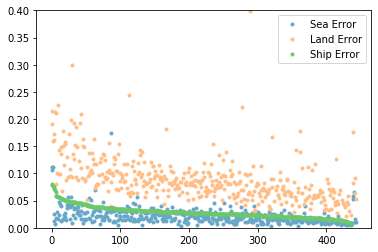

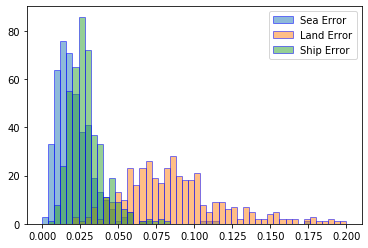

In [75]:
print('Sea Error:', count_error['sea'].dropna().mean())
print('Land Error:', count_error['land'].dropna().mean())
print('Ship Error:', count_error['ship'].dropna().mean()*0.5)
plt.plot( count_error['sea'].values,'r.',label='Sea Error',color=(103/255,167/255,200/255) )
plt.plot( count_error['land'].values,'b.',label='Land Error',color=(255/255,190/255,134/255) )
plt.plot( count_error['ship'].values,'m.',label='Ship Error',color=(107/255,200/255,107/255) )
plt.ylim(0,0.4)
plt.legend()

plt.figure()
plt.hist( count_error['sea'],range=[0,0.2], bins=50,edgecolor='b',alpha=0.5,label='Sea Error');
plt.hist(count_error['land'],range=[0,0.2], bins = 50,edgecolor='b',alpha=0.5,label='Land Error');
plt.hist( count_error['ship'],range=[0,0.2], bins=50,edgecolor='b',alpha=0.5,label='Ship Error');
plt.legend()